<a href="https://colab.research.google.com/github/arijeetchoudhury100/disaster_real_fake_kaggle/blob/master/disaster_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install demoji

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import demoji
import re
import string
from tensorflow import keras
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional,Dropout,SpatialDropout1D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def clean_tweets(tweet):
  #convert to lower case
  tweet = tweet.strip().lower()
  #remove http links
  tweet = re.sub('https?://\S+','',tweet)
  #remove html tags
  tweet = re.sub('<.*?>','',tweet)
  #remove hashtags
  tweet = re.sub('#','',tweet)
  return tweet

In [6]:
tweets_train = pd.read_csv('train.csv')
tweets_test = pd.read_csv('test.csv')
print(tweets_train.head())

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]


In [7]:
print("total no. of training samples:",len(tweets_train))
print("total np. of testing samples:",len(tweets_test))

total no. of training samples: 7613
total np. of testing samples: 3263


Text(0, 0.5, 'counts')

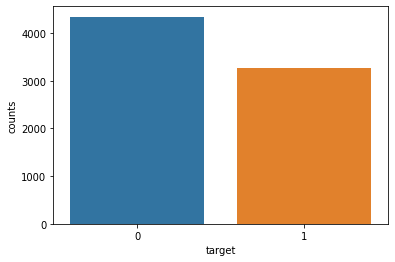

In [10]:
#check class distribution
class_dist = tweets_train['target'].value_counts()
sns.barplot(class_dist.index,class_dist)
plt.gca().set_xlabel('target')
plt.gca().set_ylabel('counts')

In [11]:
tweets_train['cleaned_text'] = tweets_train['text'].apply(clean_tweets)
print(tweets_train.head(5))

   id keyword  ... target                                       cleaned_text
0   1     NaN  ...      1  our deeds are the reason of this earthquake ma...
1   4     NaN  ...      1             forest fire near la ronge sask. canada
2   5     NaN  ...      1  all residents asked to 'shelter in place' are ...
3   6     NaN  ...      1  13,000 people receive wildfires evacuation ord...
4   7     NaN  ...      1  just got sent this photo from ruby alaska as s...

[5 rows x 6 columns]


In [12]:
demoji.download_codes()

... OK (Got response in 0.27 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [13]:
#example use of demoji
tweet = """\
... #startspreadingthenews yankees win great start by 🎅🏾 going 5strong innings with 5k’s🔥 🐂
... solo homerun 🌋🌋 with 2 solo homeruns and👹 3run homerun… 🤡 🚣🏼 👨🏽‍⚖️ with rbi’s … 🔥🔥
... 🇲🇽 and 🇳🇮 to close the game🔥🔥!!!….
... WHAT A GAME!!..
... """
demoji.findall(tweet)
tweet = demoji.replace(tweet,'')
print(tweet)

... #startspreadingthenews yankees win great start by  going 5strong innings with 5k’s 
... solo homerun  with 2 solo homeruns and 3run homerun…    with rbi’s … 
...  and  to close the game!!!….
... WHAT A GAME!!..
... 


In [0]:
def remove_emojis(tweet):
  tweet = demoji.replace(tweet,'')
  return tweet

In [15]:
tweets_train['cleaned_text'] = tweets_train['cleaned_text'].apply(remove_emojis)
print(tweets_train.head(2))

   id keyword  ... target                                       cleaned_text
0   1     NaN  ...      1  our deeds are the reason of this earthquake ma...
1   4     NaN  ...      1             forest fire near la ronge sask. canada

[2 rows x 6 columns]


In [0]:
#remove punctuations
#reference: https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
def remove_punctuation(tweet): 
    # punctuation marks 
    translator = str.maketrans('','',string.punctuation)
    return tweet.translate(translator)

In [17]:
tweets_train['cleaned_text'] = tweets_train['cleaned_text'].apply(remove_punctuation)
print(tweets_train.head(2))

   id keyword  ... target                                       cleaned_text
0   1     NaN  ...      1  our deeds are the reason of this earthquake ma...
1   4     NaN  ...      1              forest fire near la ronge sask canada

[2 rows x 6 columns]


In [18]:
#create training set
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
data = []
for tweet in tweets_train['cleaned_text']:
  words = tweet.split()
  temp = [word for word in words if word not in stopword and word.isalpha()==1]
  data.append(" ".join(temp))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
print(len(data))

7613


In [20]:
labels = tweets_train['target'].values
print(len(labels))

7613


In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index)
print('total no. of words:',vocab_size)

total no. of words: 16117


In [60]:
#convert text to sequence of tokens
sequences = tokenizer.texts_to_sequences(data)
max_len = max([len(s) for s in sequences])
print('max sequence length =',max_len)
#pad the sequences
padded_sequences =  pad_sequences(sequences,maxlen=max_len,padding='post')

max sequence length = 23


In [0]:
def load_glove(path):
  word_to_embedding = {}
  with open(path) as fh:
    for line in fh:
      line = line.strip().split()
      word = line[0]
      word_to_embedding[word] = np.array(line[1:],dtype = 'float32')
  return word_to_embedding

In [24]:
word_to_embedding = load_glove('drive/My Drive/glove.6B.50d.txt')
print(len(word_to_embedding))

400000


In [0]:
#create embedding matrix
def create_embedding(word_to_embedding,vocab_size,word_index,embed_dim):
  embeddings = np.zeros((vocab_size+1,embed_dim))
  for word,idx in word_index.items():
    embed_vec = word_to_embedding.get(word)
    if embed_vec is not None:
      embeddings[idx,:] = embed_vec
  return embeddings

In [26]:
embed_dim = 50
embed_matrix = create_embedding(word_to_embedding,vocab_size,word_to_index,embed_dim)
print(embed_matrix.shape)

(16118, 50)


In [0]:
model = Sequential([
  Embedding(input_dim=vocab_size+1,output_dim=embed_dim,input_length=max_len,weights=[embed_matrix],trainable=False),
  SpatialDropout1D(0.2),
  Bidirectional(LSTM(64,dropout=0.3,recurrent_dropout=0.3,return_sequences=True)),
  Bidirectional(LSTM(32,dropout=0.2,recurrent_dropout=0.2)),
  Dense(64,activation='relu'),
  Dense(1,activation='sigmoid')
])
opt = keras.optimizers.Adam(learning_rate=0.01,decay=0.0001)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 23, 50)            805900    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 23, 50)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 23, 128)           58880     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 910,221
Trainable params: 104,321
Non-trainable params: 805,900
__________________________________________

In [61]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(padded_sequences,labels,test_size=0.15,random_state=1)
print('training size:',len(X_train))
print('validation_size:',len(X_test))

training size: 6471
validation_size: 1142


In [63]:
early = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
history = model.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),batch_size=64,callbacks=[early])

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
6471/6471 [==============================] - 19s 3ms/step - loss: 0.4337 - accuracy: 0.8061 - val_loss: 0.4499 - val_accuracy: 0.7890
Epoch 2/15
6471/6471 [==============================] - 19s 3ms/step - loss: 0.4295 - accuracy: 0.8107 - val_loss: 0.4573 - val_accuracy: 0.8012
Epoch 3/15
6471/6471 [==============================] - 19s 3ms/step - loss: 0.4221 - accuracy: 0.8125 - val_loss: 0.4643 - val_accuracy: 0.7995
Epoch 4/15
6471/6471 [==============================] - 19s 3ms/step - loss: 0.4139 - accuracy: 0.8142 - val_loss: 0.4381 - val_accuracy: 0.7986
Epoch 5/15
6471/6471 [==============================] - 19s 3ms/step - loss: 0.4182 - accuracy: 0.8141 - val_loss: 0.4421 - val_accuracy: 0.8021
Epoch 6/15
6471/6471 [==============================] - 18s 3ms/step - loss: 0.4043 - accuracy: 0.8209 - val_loss: 0.4427 - val_accuracy: 0.8021
Epoch 7/15
6471/6471 [==============================] - 18s 3ms/step - loss: 0.407

In [49]:
test_data = pd.read_csv('test.csv')
print(test_data.head())
print(len(test_data))

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan
3263


In [64]:
test_data['text'] = test_data['text'].apply(clean_tweets)
test_data['text'] = test_data['text'].apply(remove_emojis)
test_data['text'] = test_data['text'].apply(remove_punctuation)
data_test = []
for tweet in test_data['text']:
  words = tweet.split()
  temp = [word for word in words if word not in stopword and word.isalpha()==1]
  data_test.append(" ".join(temp))
test_sequences = tokenizer.texts_to_sequences(data_test)
test_max_len = max([len(s) for s in test_sequences])
print('max sequence length =',test_max_len)
#pad the sequences
test_padded_sequences =  pad_sequences(test_sequences,maxlen=max_len,padding='post')

max sequence length = 18


In [0]:
predictions = model.predict(test_padded_sequences)

In [0]:
predictions = np.round(predictions).astype(int).reshape(3263)
#print(predictions)
submission = pd.DataFrame({'id':test_data['id'].values.tolist(),'target':predictions})
submission.to_csv('submission3.csv',index=False)

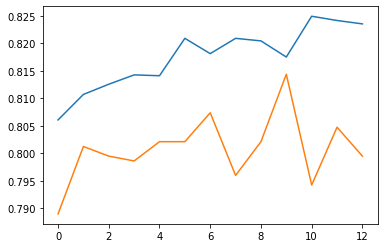

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc)
plt.plot(val_acc)